In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import os
import yaml
import json
# Set up the state
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool - a search tool
# We'll also have one "fake" tool - a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

# Set up the model
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

import my_db_specifics as my_db_specifics
from langchain_community.vectorstores import LanceDB
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain.chains import create_sql_query_chain
from langchain_openai import OpenAIEmbeddings

from langchain_core.prompts import FewShotPromptTemplate
from langchain_core.prompts import PromptTemplate

from sqlalchemy import create_engine
from langchain_community.utilities import SQLDatabase
# Set up memory
from langgraph.checkpoint.memory import MemorySaver

# Build the graph

from langgraph.graph import END, StateGraph

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
import duckdb

from typing import Literal

from typing import Annotated

from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

import utils.my_langchain_tools as my_langchain_tools
import graph_definition

In [2]:
with open("config.yaml", "r") as stream:
    try:
        PARAM = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

os.environ["OPENAI_API_KEY"] = PARAM['openai_api']

embeddings = OpenAIEmbeddings(
    model=PARAM['vector_embedding_model']
)

llm = ChatOpenAI(model="gpt-4o", temperature=0)


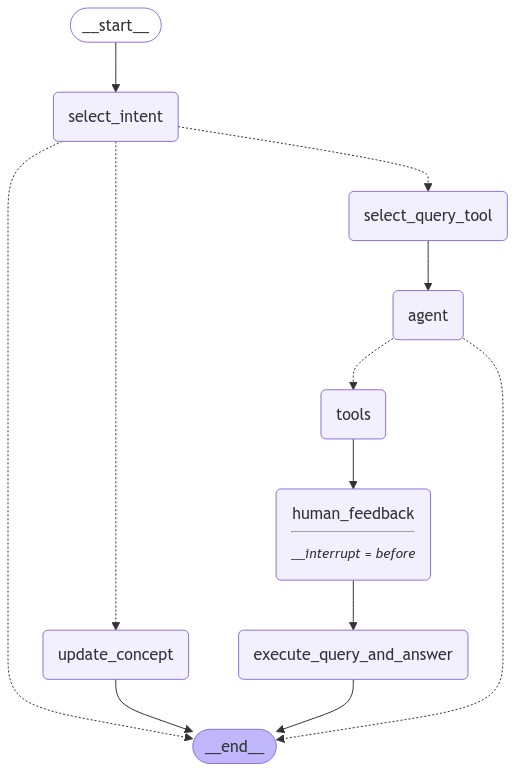

In [3]:
display(Image(graph_definition.app.get_graph(xray=1).draw_mermaid_png()))

In [4]:
database_description = my_db_specifics.graph_database_prompt
examples = my_db_specifics.graph_examples
examples

[{'input': 'What is the MOA of Nicotinamide? Use the graph query.',
  'query': "FROM GRAPH_TABLE (drug_graph\n    MATCH\n        (d:Drug WHERE LOWER(d.name) = LOWER('Nicotinamide'))-[h:HAS_MOA]->(m:MOA)\n    COLUMNS (m.name AS moa_name)\n    );\n    ",
  'tool_name': 'graph'},
 {'input': "Which drugs can be used to treat Alzheimer's Disease? Only give me all results without limit.",
  'query': "FROM GRAPH_TABLE (drug_graph\n    MATCH\n        (i:Drug)-[m:MAY_TREAT]->(c:Disorder WHERE LOWER(c.name) = LOWER('Alzheimer''s Disease'))\n    COLUMNS (i.name AS drug_name)\n    );\n                    ",
  'tool_name': 'graph'},
 {'input': "What is the mechanism of action of drugs that can treat Alzheimer's Disease? Give me 5 drugs and their MOA.",
  'query': "FROM GRAPH_TABLE (drug_graph\n    MATCH\n        (mo:MOA)<-[h:HAS_MOA]-(i:Drug)-[m:MAY_TREAT]->(c:Disorder WHERE LOWER(c.name) = LOWER('Alzheimer''s Disease'))\n    COLUMNS (i.name AS drug_name, mo.name AS moa_name)\n    );\n            "

In [5]:
example_selector = SemanticSimilarityExampleSelector.from_examples(
        examples,
        OpenAIEmbeddings(),
        LanceDB,
        k=2,
        input_keys=["input"],
        #example_keys=[""],
    )

In [6]:
example_selector.select_examples({"input": "What diseases can hydroflumethiazide treat?"})

[{'input': 'What diseases can etoposide treat? Only give me all results without limit.',
  'query': "FROM GRAPH_TABLE (drug_graph  \n    MATCH  \n        (i:Drug WHERE LOWER(i.name) = LOWER('etoposide'))-[m:MAY_TREAT]->(c:Disorder)  \n    COLUMNS (c.name AS disorder_name)  \n    );\n                    ",
  'tool_name': 'graph'},
 {'input': "What disorders can drugs with the 'GABA B receptor interactions' MOA treat? Give me 3 drugs and their targeting disorders.",
  'query': "FROM GRAPH_TABLE (drug_graph\n    MATCH\n        (mo:MOA WHERE LOWER(mo.name) = LOWER('GABA B receptor interactions'))<-[h:HAS_MOA]-(i:Drug)-[m:MAY_TREAT]->(c:Disorder)\n    COLUMNS (i.name AS drug_name, c.name AS disorder_name)\n    );\n            ",
  'tool_name': 'graph'}]

In [7]:
config = {"configurable": {"thread_id": "1", "user_id": "sixing"}}

input_message = HumanMessage(
    content="""What diseases can hydroflumethiazide treat?""", tool_choice="graph"
    #content="""Calculate the amount of trials sponsored by each of "the Three small guys".""", tool_choice="sql"
)

for event in graph_definition.app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print ("len:", len(event["messages"]))

print (graph_definition.app.get_state(config).values["messages"][-1])

tool_call_id = graph_definition.app.get_state(config).values["messages"][-1].tool_call_id
tool_name = graph_definition.app.get_state(config).values["messages"][-1].name
tool_content = graph_definition.app.get_state(config).values["messages"][-1].content

# We now create the tool call with the id and the response we want
tool_message = [
    {
     "tool_call_id": tool_call_id, 
     "name": tool_name, 
     #"type": "tool",
     "type": "human",
        "content": tool_content}
]

# # This is equivalent to the below, either one works
# from langchain_core.messages import ToolMessage
# tool_message = [ToolMessage(tool_call_id=tool_call_id, content="san francisco")]

# We now update the state
# Notice that we are also specifying `as_node="ask_human"`
# This will apply this update as this node,
# which will make it so that afterwards it continues as normal
graph_definition.app.update_state(config, {"messages": tool_message}, as_node="human_feedback")
events = list(graph_definition.app.stream(None, config, stream_mode="values"))
last_event = events[-1]
print (last_event["messages"][-1].content)

len: 1
Before response
---select_intent---
response:  content='' additional_kwargs={'tool_calls': [{'id': 'call_YTIZsoSW3e0LyVmmJpGr25DV', 'function': {'arguments': '{"action_type":"select_query_tool"}', 'name': 'Choose_Direction'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 289, 'total_tokens': 308, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-33a38c60-be1e-4de6-8171-9e577478fbf1-0' tool_calls=[{'name': 'Choose_Direction', 'args': {'action_type': 'select_query_tool'}, 'id': 'call_YTIZsoSW3e0LyVmmJpGr25DV', 'type': 'tool_call'}] usage_metadata={'input_tokens': 289, 'output_tokens': 19, 'total_tokens': 308, 'input_token_details'

In [8]:
config = {"configurable": {"thread_id": "1", "user_id": "sixing"}}

input_message = HumanMessage(
    content="""Show 5 trials that tested drugs against the top 7 liver-related disorders""", tool_choice="mimicking"
    #content="""Calculate the amount of trials sponsored by each of "the Three small guys".""", tool_choice="sql"
)

for event in graph_definition.app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print ("len:", len(event["messages"]))

print (graph_definition.app.get_state(config).values["messages"][-1])

tool_call_id = graph_definition.app.get_state(config).values["messages"][-1].tool_call_id
tool_name = graph_definition.app.get_state(config).values["messages"][-1].name
tool_content = graph_definition.app.get_state(config).values["messages"][-1].content

# We now create the tool call with the id and the response we want
tool_message = [
    {
     "tool_call_id": tool_call_id, 
     "name": tool_name, 
     #"type": "tool",
     "type": "human",
        "content": tool_content}
]

# # This is equivalent to the below, either one works
# from langchain_core.messages import ToolMessage
# tool_message = [ToolMessage(tool_call_id=tool_call_id, content="san francisco")]

# We now update the state
# Notice that we are also specifying `as_node="ask_human"`
# This will apply this update as this node,
# which will make it so that afterwards it continues as normal
graph_definition.app.update_state(config, {"messages": tool_message}, as_node="human_feedback")
events = list(graph_definition.app.stream(None, config, stream_mode="values"))
last_event = events[-1]
print (last_event["messages"][-1].content)

len: 8
Before response
---select_intent---
response:  content='' additional_kwargs={'tool_calls': [{'id': 'call_4mTVMhHDl0QemMmmHuBRhZTP', 'function': {'arguments': '{"action_type":"select_query_tool"}', 'name': 'Choose_Direction'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 632, 'total_tokens': 651, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-e2d2c45b-b39a-4099-99d8-60453bcb4698-0' tool_calls=[{'name': 'Choose_Direction', 'args': {'action_type': 'select_query_tool'}, 'id': 'call_4mTVMhHDl0QemMmmHuBRhZTP', 'type': 'tool_call'}] usage_metadata={'input_tokens': 632, 'output_tokens': 19, 'total_tokens': 651, 'input_token_details'

In [9]:
config = {"configurable": {"thread_id": "1", "user_id": "sixing"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="""The "Three Small Guys" pharmaceutical companies are Astellas, Novartis, and ViiV""")]

# Run the graph
for chunk in graph_definition.app.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

The "Three Small Guys" pharmaceutical companies are Astellas, Novartis, and ViiV
Before response


2024-11-22 19:25:10.074 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-22 19:25:10.075 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2024-11-22 19:25:10.076 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


---select_intent---
response:  content='' additional_kwargs={'tool_calls': [{'id': 'call_BbnYMzW6NWuYXHItZSSTlNqY', 'function': {'arguments': '{"action_type":"update_concept"}', 'name': 'Choose_Direction'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1418, 'total_tokens': 1437, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-65d48a4a-01aa-4455-acaf-42508150fa42-0' tool_calls=[{'name': 'Choose_Direction', 'args': {'action_type': 'update_concept'}, 'id': 'call_BbnYMzW6NWuYXHItZSSTlNqY', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1418, 'output_tokens': 19, 'total_tokens': 1437, 'input_token_details': {'audio': 0, 'cache_rea

In [10]:
config = {"configurable": {"thread_id": "1", "user_id": "sixing"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="""We also define "the Market leader" company as GSK""")]
#input_messages = [HumanMessage(content="""'Four Horsemen' are cardiovascular disease, cancer, neurodegenerative disease, and foundational disease""")]

# Run the graph
for chunk in graph_definition.app.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

We also define "the Market leader" company as GSK
Before response


2024-11-22 19:25:11.737 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-22 19:25:11.738 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


---select_intent---
response:  content='' additional_kwargs={'tool_calls': [{'id': 'call_6C8SUAwzy1H8bR2dkG6hrUnB', 'function': {'arguments': '{"action_type":"update_concept"}', 'name': 'Choose_Direction'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1464, 'total_tokens': 1483, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-6951dbc0-47d3-42b7-9009-84fe6f6c7a5b-0' tool_calls=[{'name': 'Choose_Direction', 'args': {'action_type': 'update_concept'}, 'id': 'call_6C8SUAwzy1H8bR2dkG6hrUnB', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1464, 'output_tokens': 19, 'total_tokens': 1483, 'input_token_details': {'audio': 0, 'cache_

In [11]:
config = {"configurable": {"thread_id": "1", "user_id": "sixing"}}

input_message = HumanMessage(
    content="""Tabulate the amount of trials sponsored by "the Three small guys".""", tool_choice="sql"
    #content="""Calculate the amount of trials sponsored by each of "the Three small guys".""", tool_choice="sql"
)

for event in graph_definition.app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print ("len:", len(event["messages"]))

len: 21
Before response
---select_intent---
response:  content='' additional_kwargs={'tool_calls': [{'id': 'call_FixZDNScYgtmHjosgoJwOIyC', 'function': {'arguments': '{"action_type":"select_query_tool"}', 'name': 'Choose_Direction'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1512, 'total_tokens': 1531, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-91cdf93c-3fe6-460a-bcb0-faeaa1146b64-0' tool_calls=[{'name': 'Choose_Direction', 'args': {'action_type': 'select_query_tool'}, 'id': 'call_FixZDNScYgtmHjosgoJwOIyC', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1512, 'output_tokens': 19, 'total_tokens': 1531, 'input_token_

/Users/dgg32/anaconda3/envs/langgraph/lib/python3.13/site-packages/duckdb_engine/__init__.py:600: SAWarning: PostgreSQL format_type() returned NULL for column 'definitionEmbedding'
  columns = self._get_columns_info(rows, domains, enums, schema)  # type: ignore[attr-defined]
/Users/dgg32/anaconda3/envs/langgraph/lib/python3.13/site-packages/duckdb_engine/__init__.py:600: SAWarning: Did not recognize type 'list' of column 'drug_cui'
  columns = self._get_columns_info(rows, domains, enums, schema)  # type: ignore[attr-defined]
/Users/dgg32/anaconda3/envs/langgraph/lib/python3.13/site-packages/duckdb_engine/__init__.py:600: SAWarning: Did not recognize type 'list' of column 'drug_names'
  columns = self._get_columns_info(rows, domains, enums, schema)  # type: ignore[attr-defined]
/Users/dgg32/anaconda3/envs/langgraph/lib/python3.13/site-packages/duckdb_engine/__init__.py:600: SAWarning: Did not recognize type 'list' of column 'source_pk'
  columns = self._get_columns_info(rows, domains, e

write_query first=RunnableAssign(mapper={
  input: RunnableLambda(...),
  table_info: RunnableLambda(...)
}) middle=[RunnableLambda(lambda x: {k: v for k, v in x.items() if k not in ('question', 'table_names_to_use')}), FewShotPromptTemplate(input_variables=['input', 'table_info'], input_types={}, partial_variables={'top_k': '5'}, example_selector=SemanticSimilarityExampleSelector(vectorstore=<langchain_community.vectorstores.lancedb.LanceDB object at 0x12819efd0>, k=5, example_keys=None, input_keys=['input'], vectorstore_kwargs=None), example_prompt=PromptTemplate(input_variables=['input', 'query'], input_types={}, partial_variables={}, template='User input: {input}\nSQL query: {query}'), suffix='User input: {input}\nSQL query: ', prefix="You are a DuckDB expert. Given an input question, create a syntactically correct DuckDB query to run. Ignore the {top_k} parameter for now.\n        Here is the relevant table info: {table_info}\n        - If the search term contains a single quote, 

In [12]:
print (graph_definition.app.get_state(config).values["messages"][-1])

tool_call_id = graph_definition.app.get_state(config).values["messages"][-1].tool_call_id
tool_name = graph_definition.app.get_state(config).values["messages"][-1].name
tool_content = graph_definition.app.get_state(config).values["messages"][-1].content

# We now create the tool call with the id and the response we want
tool_message = [
    {
     "tool_call_id": tool_call_id, 
     "name": tool_name, 
     #"type": "tool",
     "type": "human",
        "content": tool_content}
]

# # This is equivalent to the below, either one works
# from langchain_core.messages import ToolMessage
# tool_message = [ToolMessage(tool_call_id=tool_call_id, content="san francisco")]

# We now update the state
# Notice that we are also specifying `as_node="ask_human"`
# This will apply this update as this node,
# which will make it so that afterwards it continues as normal
graph_definition.app.update_state(config, {"messages": tool_message}, as_node="human_feedback")
events = list(graph_definition.app.stream(None, config, stream_mode="values"))
last_event = events[-1]
print (last_event["messages"][-1].content)

content="SELECT Sponsor, COUNT(*) AS TrialCount \nFROM Trials \nWHERE Sponsor IN ('Astellas', 'Novartis', 'ViiV') \nGROUP BY Sponsor\n LIMIT 50;" name='sql' id='706718d3-c92f-4c59-b654-0b56d1718e8f' tool_call_id='call_AldpqkdPBSnKknGTCVDWjS7c'
---execute_query_and_answer---
question SELECT Sponsor, COUNT(*) as TrialCount FROM Trials WHERE Sponsor IN ('Astellas', 'Novartis', 'ViiV') GROUP BY Sponsor
query SELECT Sponsor, COUNT(*) AS TrialCount 
FROM Trials 
WHERE Sponsor IN ('Astellas', 'Novartis', 'ViiV') 
GROUP BY Sponsor
 LIMIT 50;
m human content="SELECT Sponsor, COUNT(*) AS TrialCount \nFROM Trials \nWHERE Sponsor IN ('Astellas', 'Novartis', 'ViiV') \nGROUP BY Sponsor\n LIMIT 50;" additional_kwargs={} response_metadata={} name='sql' id='652020e6-838a-42a7-aa08-6cfc6eabfa4f' tool_call_id='call_AldpqkdPBSnKknGTCVDWjS7c'
m tool content="SELECT Sponsor, COUNT(*) AS TrialCount \nFROM Trials \nWHERE Sponsor IN ('Astellas', 'Novartis', 'ViiV') \nGROUP BY Sponsor\n LIMIT 50;" name='sql' id

In [13]:
config = {"configurable": {"thread_id": "1", "user_id": "sixing"}}

input_message = HumanMessage(
    #content="""Tabulate the amount of trials sponsored by "the Three small guys".""", tool_choice="sql"
    content="""Calculate the amount of trials sponsored by the market leader.""", tool_choice="sql"
)

for event in graph_definition.app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print ("len:", len(event["messages"]))

len: 28
Before response
---select_intent---
response:  content='' additional_kwargs={'tool_calls': [{'id': 'call_XzJ41uh35e3DbUk1gtc6L9t1', 'function': {'arguments': '{"action_type":"select_query_tool"}', 'name': 'Choose_Direction'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1790, 'total_tokens': 1809, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1408}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-c03e4533-dea4-4242-bd34-8efe2afcebba-0' tool_calls=[{'name': 'Choose_Direction', 'args': {'action_type': 'select_query_tool'}, 'id': 'call_XzJ41uh35e3DbUk1gtc6L9t1', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1790, 'output_tokens': 19, 'total_tokens': 1809, 'input_token_

/Users/dgg32/anaconda3/envs/langgraph/lib/python3.13/site-packages/duckdb_engine/__init__.py:600: SAWarning: PostgreSQL format_type() returned NULL for column 'definitionEmbedding'
  columns = self._get_columns_info(rows, domains, enums, schema)  # type: ignore[attr-defined]
/Users/dgg32/anaconda3/envs/langgraph/lib/python3.13/site-packages/duckdb_engine/__init__.py:600: SAWarning: Did not recognize type 'list' of column 'drug_cui'
  columns = self._get_columns_info(rows, domains, enums, schema)  # type: ignore[attr-defined]
/Users/dgg32/anaconda3/envs/langgraph/lib/python3.13/site-packages/duckdb_engine/__init__.py:600: SAWarning: Did not recognize type 'list' of column 'drug_names'
  columns = self._get_columns_info(rows, domains, enums, schema)  # type: ignore[attr-defined]
/Users/dgg32/anaconda3/envs/langgraph/lib/python3.13/site-packages/duckdb_engine/__init__.py:600: SAWarning: Did not recognize type 'list' of column 'source_pk'
  columns = self._get_columns_info(rows, domains, e

write_query first=RunnableAssign(mapper={
  input: RunnableLambda(...),
  table_info: RunnableLambda(...)
}) middle=[RunnableLambda(lambda x: {k: v for k, v in x.items() if k not in ('question', 'table_names_to_use')}), FewShotPromptTemplate(input_variables=['input', 'table_info'], input_types={}, partial_variables={'top_k': '5'}, example_selector=SemanticSimilarityExampleSelector(vectorstore=<langchain_community.vectorstores.lancedb.LanceDB object at 0x12819eea0>, k=5, example_keys=None, input_keys=['input'], vectorstore_kwargs=None), example_prompt=PromptTemplate(input_variables=['input', 'query'], input_types={}, partial_variables={}, template='User input: {input}\nSQL query: {query}'), suffix='User input: {input}\nSQL query: ', prefix="You are a DuckDB expert. Given an input question, create a syntactically correct DuckDB query to run. Ignore the {top_k} parameter for now.\n        Here is the relevant table info: {table_info}\n        - If the search term contains a single quote, 

In [14]:
print (graph_definition.app.get_state(config).values["messages"][-1])

tool_call_id = graph_definition.app.get_state(config).values["messages"][-1].tool_call_id
tool_name = graph_definition.app.get_state(config).values["messages"][-1].name
tool_content = graph_definition.app.get_state(config).values["messages"][-1].content

# We now create the tool call with the id and the response we want
tool_message = [
    {"tool_call_id": tool_call_id, "name": tool_name, 
     #"type": "tool",
     "type": "human",
    "content": tool_content}
]

# # This is equivalent to the below, either one works
# from langchain_core.messages import ToolMessage
# tool_message = [ToolMessage(tool_call_id=tool_call_id, content="san francisco")]

# We now update the state
# Notice that we are also specifying `as_node="ask_human"`
# This will apply this update as this node,
# which will make it so that afterwards it continues as normal
graph_definition.app.update_state(config, {"messages": tool_message}, as_node="human_feedback")
events = list(graph_definition.app.stream(None, config, stream_mode="values"))
last_event = events[-1]
print (last_event["messages"][-1].content)

content="SELECT COUNT(PostingID) AS trial_count \nFROM Trials \nWHERE LOWER(Sponsor) = LOWER('GSK')\n LIMIT 50;" name='sql' id='773f4dd9-0964-4695-b77a-8d9ef81c7881' tool_call_id='call_ERn85u25GzjIPLqhOXTWPAhz'
---execute_query_and_answer---
question Calculate the amount of trials sponsored by GSK.
query SELECT COUNT(PostingID) AS trial_count 
FROM Trials 
WHERE LOWER(Sponsor) = LOWER('GSK')
 LIMIT 50;
m human content="SELECT COUNT(PostingID) AS trial_count \nFROM Trials \nWHERE LOWER(Sponsor) = LOWER('GSK')\n LIMIT 50;" additional_kwargs={} response_metadata={} name='sql' id='ca4bc251-c95a-4b5d-bd78-12bc0029200e' tool_call_id='call_ERn85u25GzjIPLqhOXTWPAhz'
m tool content="SELECT COUNT(PostingID) AS trial_count \nFROM Trials \nWHERE LOWER(Sponsor) = LOWER('GSK')\n LIMIT 50;" name='sql' id='773f4dd9-0964-4695-b77a-8d9ef81c7881' tool_call_id='call_ERn85u25GzjIPLqhOXTWPAhz'
return tool_call_id call_ERn85u25GzjIPLqhOXTWPAhz
The amount of trials sponsored by GSK is 1705. 

Here is the info

In [15]:
events

[{'messages': [HumanMessage(content='What diseases can hydroflumethiazide treat?', additional_kwargs={}, response_metadata={}, id='4a5b31cb-5ab5-4f81-a04e-43bb334139ac', tool_choice='graph'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YTIZsoSW3e0LyVmmJpGr25DV', 'function': {'arguments': '{"action_type":"select_query_tool"}', 'name': 'Choose_Direction'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 289, 'total_tokens': 308, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-33a38c60-be1e-4de6-8171-9e577478fbf1-0', tool_calls=[{'name': 'Choose_Direction', 'args': {'action_type': 'select_query_tool'}, 'id': 

In [16]:
input_message = HumanMessage(
    content="""Thank you very much""", tool_choice="automatic"
    #content="""Calculate the amount of trials sponsored by each of "the Three small guys".""", tool_choice="sql"
)

for event in graph_definition.app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print ("len:", len(event["messages"]))

len: 35
Before response
---select_intent---
response:  content="You're welcome! If you have any more questions or need further assistance, feel free to ask. Have a great day!" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1971, 'total_tokens': 1996, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1664}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'stop', 'logprobs': None} id='run-3d70228f-8083-498b-acec-65957b6d3adb-0' usage_metadata={'input_tokens': 1971, 'output_tokens': 25, 'total_tokens': 1996, 'input_token_details': {'audio': 0, 'cache_read': 1664}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
---route_message---
 message: [HumanMessage(content='What diseases can hydroflumethiazide treat?', additional_kwargs=